In [10]:
import pandas as pd
#import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import gym


# 아래의 방식을 통해 게임을 등록함. 특히 is_slippery는 매우 중요함. 
"""
- 새로운 게임 형식을 만들어줌.
"""


'\n- 새로운 게임 형식을 만들어줌.\n'

In [23]:
import gym 
from gym.envs.registration import register

register(
    id='FrozenLakeNotSlippery-v2',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
)

In [25]:
env = gym.make("FrozenLakeNotSlippery-v2")
env.reset()
"""
0: left, 1: down, 2: right, 3: up 
"""
complete_actions = [2, 2, 1, 1, 1, 2]
for action in complete_actions:
    #action = env.action_space.sample() # randomly select action 
    """
    - new_state: 액션을 취해서 새롭게 옮겨진 위치 
    - reward: 보상을 얻었는지 여부
    - done: 게임이 끝났는지 여부(hole에 빠지거나, )
    """
    new_state, reward, done, _ = env.step(action)# action을 적용하고 업데이트
    env.render() #현재 상황을 보여줌
    if done is True:
        print("done, reward: {}".format(reward))

  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
done, reward: 1.0


complete


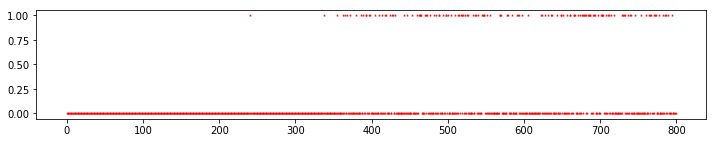

            left      down     right        up
(0, 0)  0.941480  0.950990  0.950990  0.941480
(0, 1)  0.941480  0.000000  0.960596  0.950990
(0, 2)  0.950990  0.970299  0.950990  0.960596
(0, 3)  0.960596  0.000000  0.950990  0.950990
(1, 0)  0.950990  0.960596  0.000000  0.941480
(1, 1)  0.000000  0.000000  0.000000  0.000000
(1, 2)  0.000000  0.980100  0.000000  0.960596
(1, 3)  0.000000  0.000000  0.000000  0.000000
(2, 0)  0.960596  0.000000  0.970299  0.950990
(2, 1)  0.960596  0.980100  0.980100  0.000000
(2, 2)  0.970299  0.990000  0.000000  0.970299
(2, 3)  0.000000  0.000000  0.000000  0.000000
(3, 0)  0.000000  0.000000  0.000000  0.000000
(3, 1)  0.000000  0.980100  0.990000  0.970299
(3, 2)  0.980100  0.990000  1.000000  0.980100
(3, 3)  0.000000  0.000000  0.000000  0.000000


In [26]:
"""
- 사실 이런 형태의 미로에서는 reward를 끝나봐야 얻습니다. 끝날때까지 reward가 어디있는지 모른다는 이야기죠. 
- 비슷하게, 장기 바둑도 마찬가지입니다. 이전의 어떤 수가 reward를 결정했는지는 알기가 어려우니까요.
- 아무튼, 그러므로, dummy Q-learning algorithm에서는 t+1 state의 reward의 max값을 t state의 reward의 max 값으로 정합니다. 
    - 미래의 리워드를 현재의 리워드로 가져온다는 말이 이상하지만, 이걸 정리하면, "이번 게임에서 t+1 스텝
"""
env = gym.make("FrozenLakeNotSlippery-v1")
observation = env.reset()

"""
- Q는 개별 observation(현재 말의 위치)와 해당 obs에서 취할 수 있는 action별로 이득이 표현된 테이블입니다. 
- 뒤쪽에서 다시 설명되겠지만, 게임이 종료되었을 때 얻을 수 있는 reward가 앞으로 전달되어, 각 값을 업데이트해줍니다. 
"""
Q = np.zeros([env.observation_space.n, env.action_space.n])

num_episodes = 800 # 일종의 epoch, 혹은 라이프.
decay_rate = 0.99 
# reward는 전달 과정에서 누가 계속 까먹기 때문에, decay rate가 발생함. 
# 사실 맨 끝에서 얻은 Reward가 앞가지 전달되는데 아무런 변화가 없어야 한다는 것도, 직관적으로 이상하지 않나요? 
# 또한, 이렇게 모델링 해야, 짧은 path를 거쳐 지나온 놈의 경우에 step에서 높은 Q(partial reward)를 가짐 

rlist = []
for i in range(0, num_episodes):
    state = env.reset()
    e = 1. / ((i//100)+1)
    """
    goal에 이르는 답이 여러가지일 수 있는데, 어느 정도의 랜덤성을 통해서 탐험을 하지 않을 경우, 초기의 답만을 가지게 됨. 
    사실 미로의 경우는 탐험을 통해 더 짧은 길을 찾을 수도 있습니다. 
    따라서, 여기서는 이미, 최적의 path를 찾았다고 해도 다시 더 좋은 path를 찾을 수 있도록 exploration을 보장합니다. 
    """
    #env.render()
    rAll = 0 # 한 episode 별로 얻을 수 있는 reward의 총합
    done = False # hole에 빠지거나, Goal에 도달하면 True
    while not done:
        if np.random.randn(1) < e: # 탐험을 통해 더 좋은 길을 확보
            # np.random.randn 은 norm(0, 1)
            # 즉, 에피소드가 반복되어 e가 감소되어도, 대략 0.5 정도의 확률로 탐험을 하는 것이 가능해야 함. 
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state, :])
        new_state, reward, done, _ = env.step(action)
        # 다음 단계로 가서 리워드를 얻는 다면, 이전단계까지 잘 온 것이므로 이전 단계에도 리워드를 준다. 
        Q[state, action] = reward + decay_rate*np.max(Q[new_state, :])
        rAll+=reward
        state = new_state # state update
    rlist.append(rAll)
print('complete')

"""
- 처음에는 잘 못 맞추다가, 한 두번 맞추기 시작하면서 부터는 슥슥 매우 잘 맞춤
- 그냥 random으로 시행할 경우에는, 1.3%의 확률로 reward 획득
"""
plt.figure(figsize=(12, 2))
plt.scatter(range(0, len(rlist)), rlist, marker='^', s=1, color='red')
plt.savefig('../../assets/images/markdown_img/180625_reinforcement_base.svg')
plt.show()

"""
0: left, 1: down, 2: right, 3: up 
"""
#print(Q)
Q_df = pd.DataFrame(Q, index = [(i//4, i%4) for i in range(0, Q.shape[0])], 
                    columns=['left', 'down', 'right', 'up'])
print(Q_df)



score: 0.059


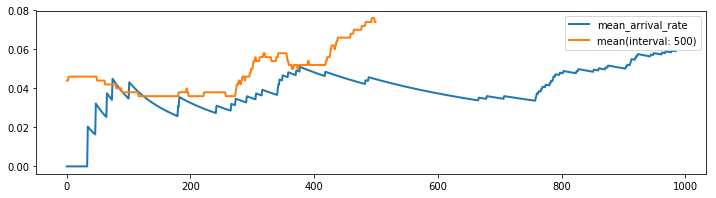

            left          down     right            up
(0, 0)  0.003622  4.863928e-03  0.003052  7.031821e-03
(0, 1)  0.001646  1.732608e-04  0.000183  2.411605e-03
(0, 2)  0.000178  7.245257e-05  0.000221  1.878010e-03
(0, 3)  0.000020  3.765731e-05  0.000165  2.064030e-04
(1, 0)  0.068927  9.249168e-05  0.000016  2.208762e-04
(1, 1)  0.000000  0.000000e+00  0.000000  0.000000e+00
(1, 2)  0.002250  4.745120e-05  0.000452  3.177189e-09
(1, 3)  0.000000  0.000000e+00  0.000000  0.000000e+00
(2, 0)  0.000024  9.018315e-07  0.000996  6.297898e-01
(2, 1)  0.001951  1.064798e-01  0.001008  5.438256e-05
(2, 2)  0.089212  5.489676e-06  0.001467  3.964609e-04
(2, 3)  0.000000  0.000000e+00  0.000000  0.000000e+00
(3, 0)  0.000000  0.000000e+00  0.000000  0.000000e+00
(3, 1)  0.001013  2.687749e-05  0.882613  6.007486e-04
(3, 2)  0.000000  5.383935e-03  0.001170  8.907458e-01
(3, 3)  0.000000  0.000000e+00  0.000000  0.000000e+00


In [115]:
"""
- FrozenLake-v0 의 경우, is_slippery가 True임. 가라는대로 가지 않음. 
- 이렇게, 결정되지 않고, 확률적인 상황에 따라서 결정되는 것을 stochastic, non-deterministic하다고 함
"""
env = gym.make("FrozenLake-v0")
Q = np.zeros([env.observation_space.n, env.action_space.n])

#def r_list_grid(lrs=[], num_eps=[]):
    
learning_rate = 0.9
num_episodes = 1000
decay_rate = 0.99 

rlist = []
for i in range(0, num_episodes):
    state = env.reset()
    rAll = 0 # 한 episode 별로 얻을 수 있는 reward의 총합
    done = False # hole에 빠지거나, Goal에 도달하면 True
    while not done:
        action = np.argmax(Q[state, :] + np.random.normal(0, 1, env.action_space.n)/(i+1))
        new_state, reward, done, _ = env.step(action)
        Q[state, action] = (1-learning_rate)*Q[state, action] 
        Q[state, action] += learning_rate*(reward + decay_rate*np.max(Q[new_state, :]))
        rAll+=reward
        state = new_state # state update
    rlist.append(rAll)
    
print("score: {}".format(sum(rlist)/len(rlist)))
plt.figure(figsize=(12, 3))
#plt.scatter(range(0, len(rlist)), rlist, marker='^', s=1, color='red')

# 누적 평균
mean_arriving_rate_lst = []
for i in range(15, len(rlist)):
    mean_arriving_rate_lst.append(sum(rlist[:i])/len(rlist[:i]))
plt.plot(range(0, len(mean_arriving_rate_lst)), mean_arriving_rate_lst, 
         linewidth=2, label = "mean_arrival_rate")
# 이전 interval 평균
mean_arriving_rate_interval_lst = []
time_interval = 500
for i in range(time_interval, len(rlist)):
    mean_arriving_rate_interval_lst.append(sum(rlist[i-time_interval:i])/len(rlist[i-time_interval:i]))
plt.plot(range(0, len(mean_arriving_rate_interval_lst)), mean_arriving_rate_interval_lst, 
         linewidth=2, label = "mean(interval: {})".format(time_interval))
plt.legend()
plt.savefig('../../assets/images/markdown_img/180625_reinforcement_stochastic.svg')
plt.show()

"""
0: left, 1: down, 2: right, 3: up 
"""
#print(Q)
Q_df = pd.DataFrame(Q, index = [(i//4, i%4) for i in range(0, Q.shape[0])], 
                    columns=['left', 'down', 'right', 'up'])
print(Q_df)


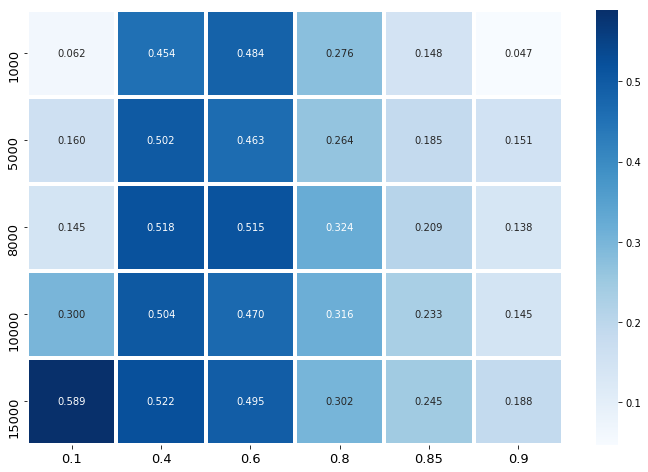

In [161]:
import seaborn as sns 

def make_rlist_grid(lrs=[], num_eps=[]):
    """
    learning rate, num_episode 에 따라서, 시행한 결과값을 nested dictionary에 넣어줌
    - 
    """
    r_dict = {lr:{ep: [] for ep in num_eps} for lr in lrs}
    env = gym.make("FrozenLake-v0")
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    
    decay_rate = 0.99 
    for lr in lrs:
        for ep in num_eps:
            for i in range(0, ep):
                state = env.reset()
                rAll = 0 # 한 episode 별로 얻을 수 있는 reward의 총합
                done = False # hole에 빠지거나, Goal에 도달하면 True
                while not done:
                    action = np.argmax(Q[state, :] + np.random.normal(0, 1, env.action_space.n)/(i+1))
                    new_state, reward, done, _ = env.step(action)
                    Q[state, action] = (1-lr)*Q[state, action] 
                    Q[state, action] += lr*(reward + decay_rate*np.max(Q[new_state, :]))
                    rAll+=reward
                    state = new_state # state update
                r_dict[lr][ep].append(rAll)
    return r_dict
lrs = [0.1, 0.4, 0.6, 0.8, 0.85, 0.9]
num_eps = [1000, 5000, 8000, 10000, 15000]
## 두번 계산하여 평균을 구함
rlist_grid = make_rlist_grid(lrs=lrs, num_eps=num_eps)
rlist_grid_score = {lr: {ep: sum(rlist_grid[lr][ep])/len(rlist_grid[lr][ep]) 
                         for ep in rlist_grid[lr].keys()} for lr in rlist_grid.keys() }

plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(rlist_grid_score), 
            annot=True, fmt=".3f",
            cmap=plt.cm.Blues, cbar=True,
            linewidths=3)
plt.tick_params(labelsize=13)
plt.savefig('../../assets/images/markdown_img/180627_reinforcement_lr_ep_heatmap.svg')
plt.show()

### lr:0.1 complete ##
### lr:0.99 complete ##


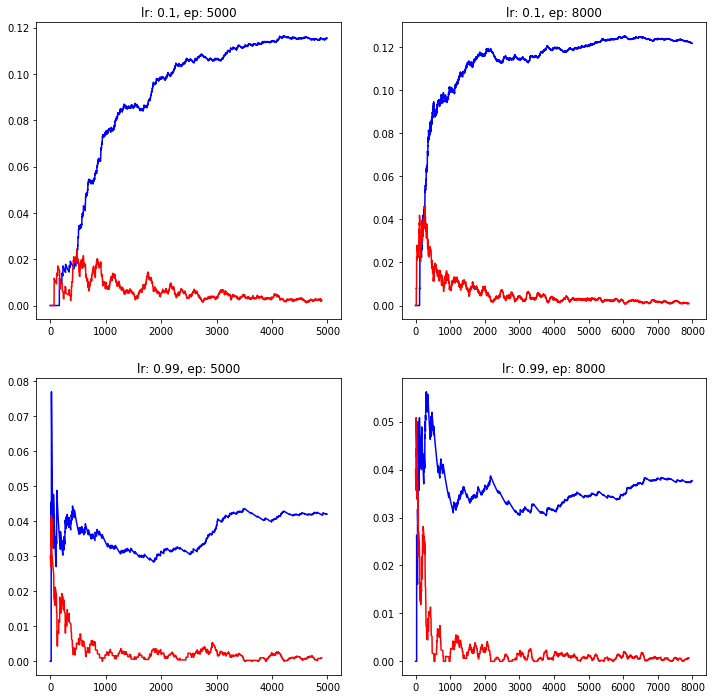

In [145]:
f, axes = plt.subplots(len(lrs), len(num_eps), figsize=(12, 12))
for i, lr in enumerate(lrs):
    for j, ep in enumerate(num_eps):
        rlist = rlist_grid[lr][ep]
        mean_arriving_lst = [sum(rlist[:i])/i for i in range(5, len(rlist))]
        mean_arriving_interval_lst = [sum(rlist[i-100:i])/i for i in range(100, len(rlist))]
        axes[i][j].plot(mean_arriving_lst, color='blue')
        axes[i][j].plot(mean_arriving_interval_lst, color ='red')
        axes[i][j].set_title("lr: {}, ep: {}".format(lr, ep))
    print("### lr:{} complete ##".format(lr, ep))
plt.show()

In [ ]:
print("score: {}".format(sum(rlist)/len(rlist)))
plt.figure(figsize=(12, 3))
#plt.scatter(range(0, len(rlist)), rlist, marker='^', s=1, color='red')

# 누적 평균
mean_arriving_rate_lst = []
for i in range(15, len(rlist)):
    mean_arriving_rate_lst.append(sum(rlist[:i])/len(rlist[:i]))
plt.plot(range(0, len(mean_arriving_rate_lst)), mean_arriving_rate_lst, 
         linewidth=2, label = "mean_arrival_rate")
# 이전 interval 평균
mean_arriving_rate_interval_lst = []
time_interval = 500
for i in range(time_interval, len(rlist)):
    mean_arriving_rate_interval_lst.append(sum(rlist[i-time_interval:i])/len(rlist[i-time_interval:i]))
plt.plot(range(0, len(mean_arriving_rate_interval_lst)), mean_arriving_rate_interval_lst, 
         linewidth=2, label = "mean(interval: {})".format(time_interval))
plt.legend()
plt.savefig('../../assets/images/markdown_img/180625_reinforcement_stochastic.svg')
plt.show()

"""
0: left, 1: down, 2: right, 3: up 
"""
#print(Q)
Q_df = pd.DataFrame(Q, index = [(i//4, i%4) for i in range(0, Q.shape[0])], 
                    columns=['left', 'down', 'right', 'up'])
print(Q_df)

In [106]:
### how to get is_slippery prob??
env = gym.make("FrozenLake-v0")
is_slippery_lst = []
for i in range(0, 10000):
    env.reset()
    new_state, reward, done, _ = env.step(2)
    if new_state==1:
        is_slippery_lst.append(False)
    else:
        is_slippery_lst.append(True)
    #env.render()
print("slippery rate: {}".format(np.array(is_slippery_lst, dtype=int).mean()))

slippery rate: 0.6708


In [ ]:
"""
0: left, 1: down, 2: right, 3: up 
"""
complete_actions = [2, 2, 1, 1, 1, 2]
for action in complete_actions:
    #action = env.action_space.sample() # randomly select action 
    """
    - new_state: 액션을 취해서 새롭게 옮겨진 위치 
    - reward: 보상을 얻었는지 여부
    - done: 게임이 끝났는지 여부(hole에 빠지거나, )
    """
    new_state, reward, done, _ = env.step(action)# action을 적용하고 업데이트
    env.render() #현재 상황을 보여줌
    if done is True:
        print("done, reward: {}".format(reward))

In [102]:
env = gym.make("FrozenLake-v0")

for i in range(0, 5):
    # 0: left, 1: down, 2: right, 3: up 
    state = env.reset()
    new_state, reward, done, _ = env.step(2)
    print("state: {} ==> state: {}".format(state, new_state))
    

state: 0 ==> state: 4
state: 0 ==> state: 4
state: 0 ==> state: 4
state: 0 ==> state: 0
state: 0 ==> state: 0
